In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from ksnunu_utils import * 

# Reinterpreting $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [2]:
binning = np.linspace(0.0, 19.25, 10+1) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 19.25, 25+1)

## Define the NP model in WC space

In [3]:
cvl = 10.0
cvr = 4.0
csl = 3.0
csr = 1.0
ctl = 1.0

## Compute number of samples to produce

In [4]:
# current lumi
lc = 362

# total lumi
lf = 50000

# current BB evts
ec = 387e6

# total BB evts
et = ec * lf / lc

## Generate some SM samples

In [5]:
p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

# SMsamples = int(ec*SMBR)
SMsamples = int(et*SMBR)

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1230))

/filer/z-sv-pool12c/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Smear samples with Gaussian resolution function
np.random.seed(4560)
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

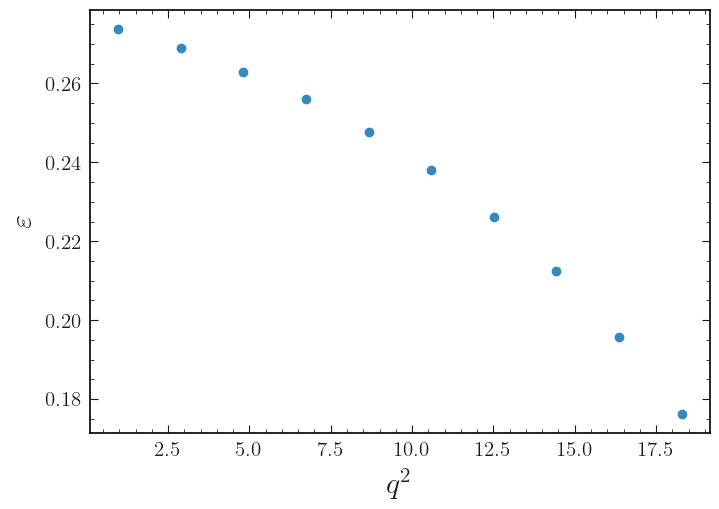

In [7]:
# plot efficiency
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [8]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=7890))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# Smear samples with Gaussian resolution function and apply efficiency
np.random.seed(1010)
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

### Plot samples and calculate yields

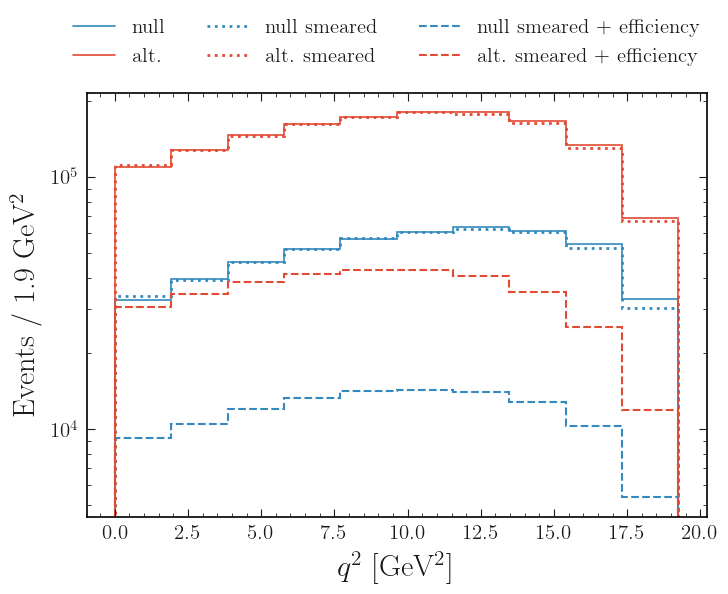

In [25]:
null_binned = np.histogram(null_samples, binning)[0]
alt_binned  = np.histogram(alt_samples,  binning)[0]

null_smeared_binned = np.histogram(null_samples_smeared, binning)[0]
alt_smeared_binned  = np.histogram(alt_samples_smeared,  binning)[0]

null_yields = np.histogram(null_samples_smeared, binning, weights = efficiency(null_samples_smeared))[0]
alt_yields  = np.histogram(alt_samples_smeared,  binning, weights = efficiency(alt_samples_smeared) )[0]

fig, ax = plt.subplots(1,1, sharex=True)

ax.stairs(null_binned, binning, color='C0', linewidth=1.2, linestyle='solid', label='null')
ax.stairs(alt_binned,  binning, color='C1', linewidth=1.2, linestyle='solid', label='alt.')
ax.stairs(null_smeared_binned, binning, color='C0', linewidth=2., linestyle='dotted', label='null smeared')
ax.stairs(alt_smeared_binned,  binning, color='C1', linewidth=2., linestyle='dotted', label='alt. smeared')
ax.stairs(null_yields, binning, label='null smeared + efficiency', color='C0', linewidth=1.5, linestyle='dashed')
ax.stairs(alt_yields,  binning, label='alt. smeared + efficiency', color='C1', linewidth=1.5, linestyle='dashed')

ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'Events / 1.9 GeV$^2$')

ax.set_yscale('log')
ax.set_yscale('log')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

file = 'results/ksnunu_data_sets.pdf'
plt.savefig(file)

plt.show()

In [11]:
print('# SM samples', SMsamples)
print('# SM yields', sum(null_yields))
print('# BSM samples', BSMBR/SMBR * SMsamples)
print('# BSM yields', sum(alt_yields))
print('ratio BSM/SM samples', BSMBR/SMBR)
print('ratio BSM/SM yields', sum(alt_yields)/sum(null_yields))

# SM samples 499239
# SM yields 116277.20307513022
# BSM samples 1452258.0622813574
# BSM yields 343430.09086703
ratio BSM/SM samples 2.9089435366254586
ratio BSM/SM yields 2.953546196369459


## Set up the mapping distribution

In [12]:
mapping_dist = modifier.map(null_samples_smeared.flatten(), [null_samples.flatten()], binning, [q2binning])
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [13]:
null = null_pred()
alt = alt_pred()

In [14]:
ana  = analysis()

v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()
a00  = ana.parameters['B->K^*::alpha^A0_0@BSZ2015' ].evaluate() 
a01  = ana.parameters['B->K^*::alpha^A0_1@BSZ2015' ].evaluate() 
a02  = ana.parameters['B->K^*::alpha^A0_2@BSZ2015' ].evaluate()
a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()
a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()
t10  = ana.parameters['B->K^*::alpha^T1_0@BSZ2015' ].evaluate()
t11  = ana.parameters['B->K^*::alpha^T1_1@BSZ2015' ].evaluate()
t12  = ana.parameters['B->K^*::alpha^T1_2@BSZ2015' ].evaluate()
t21  = ana.parameters['B->K^*::alpha^T2_1@BSZ2015' ].evaluate()
t22  = ana.parameters['B->K^*::alpha^T2_2@BSZ2015' ].evaluate()
t230 = ana.parameters['B->K^*::alpha^T23_0@BSZ2015'].evaluate()
t231 = ana.parameters['B->K^*::alpha^T23_1@BSZ2015'].evaluate()
t232 = ana.parameters['B->K^*::alpha^T23_2@BSZ2015'].evaluate()

In [15]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana, chains = 5, samples = 10000)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]            Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded
Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]            Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.001429,-0.000783,-0.063255,0.000804,0.003936,-0.000127,0.013502,0.050576,0.001198,-0.003037,-0.063048,0.000579,0.001062,0.012997,0.003999,0.013892,0.001080,0.001477,-0.019931
1,-0.000783,0.066039,0.376485,-0.001003,-0.001022,-0.019515,0.021904,0.149820,-0.003431,0.014736,0.187574,-0.000915,-0.003302,-0.073291,-0.008298,-0.054909,-0.002483,-0.003942,0.050023
2,-0.063255,0.376485,7.817416,-0.024235,-0.168423,-0.088139,-0.580625,-1.597669,-0.050883,0.092806,4.035921,-0.008688,-0.105557,-1.991418,-0.192241,-1.528172,-0.042420,0.023533,1.301351
3,0.000804,-0.001003,-0.024235,0.000880,0.003617,-0.003752,0.006871,0.027338,0.001350,-0.003249,-0.063462,0.000831,0.000335,-0.005884,0.004216,0.004411,0.001141,0.003286,-0.010230
4,0.003936,-0.001022,-0.168423,0.003617,0.028578,0.049568,0.057137,0.276662,0.006094,-0.011900,-0.335306,0.003475,0.003863,0.010220,0.019150,0.034429,0.005169,0.013039,-0.052845
5,-0.000127,-0.019515,-0.088139,-0.003752,0.049568,0.546352,0.078496,0.579064,-0.001101,-0.009386,0.020145,-0.002393,0.008470,0.179110,-0.011384,0.026917,-0.001420,-0.010562,-0.001050
6,0.013502,0.021904,-0.580625,0.006871,0.057137,0.078496,0.243404,1.237767,0.009733,-0.015594,-0.604531,0.004246,0.016193,0.225147,0.038735,0.179226,0.009345,0.001337,-0.228884
7,0.050576,0.149820,-1.597669,0.027338,0.276662,0.579064,1.237767,7.096278,0.037091,-0.053165,-2.230731,0.016978,0.073204,0.981699,0.158164,0.722044,0.037040,-0.009231,-0.950141
8,0.001198,-0.003431,-0.050883,0.001350,0.006094,-0.001101,0.009733,0.037091,0.002539,-0.006929,-0.135258,0.001352,0.000671,-0.006462,0.007119,0.009803,0.001911,0.005508,-0.018278
9,-0.003037,0.014736,0.092806,-0.003249,-0.011900,-0.009386,-0.015594,-0.053165,-0.006929,0.046410,0.409080,-0.003307,-0.000765,0.028532,-0.016105,-0.012694,-0.004814,-0.014018,0.057059


In [16]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,),  'bounds': ((6., 16.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'FFKs'    :{'inits': (v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

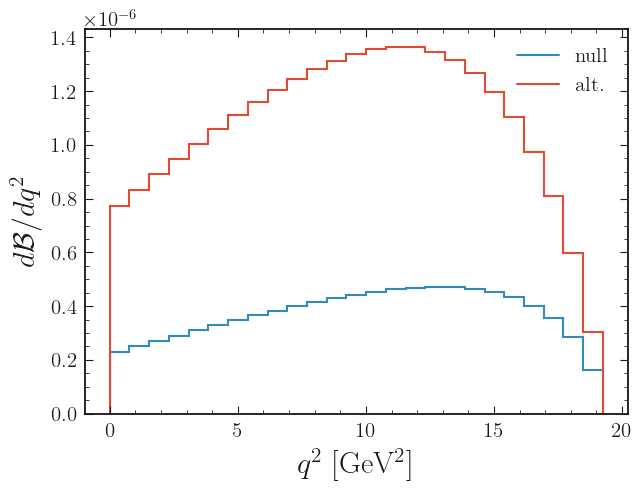

In [17]:
pars = (cvl, cvr, csl, csr, ctl, v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232)
lims = [0.0, 19.25]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

(<Figure size 800x550 with 2 Axes>,
 <Axes: xlabel='Kinematic bins', ylabel='Target bins'>)

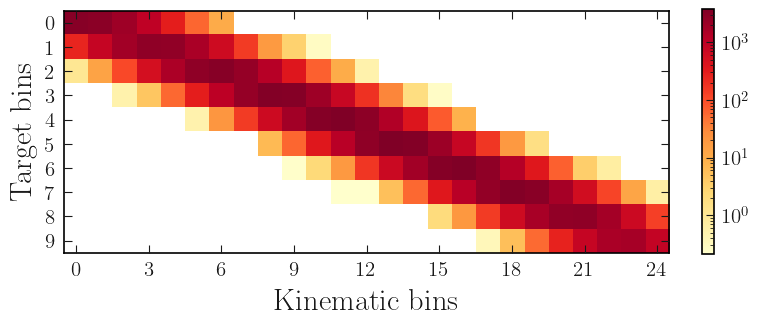

In [18]:
plot.map(cmod, cmap='YlOrRd', norm=LogNorm())

## Set up the model

In [19]:
spec = {
  "channels": [
    {
      "name": "B->K*nunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "ksnunu_theory",
                "type": "ksnunu",
                "data":
                    {"expr": "ksnunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->K*nunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->K*nunu',
   'samples': [{'name': 'signal',
     'data': [9224.389990441789,
      10550.960043761857,
      12078.891022899246,
      13313.05469574052,
      14152.05050418256,
      14366.89373656678,
      14065.252399441117,
      12875.717368726735,
      10268.35218279087,
      5381.641130578748],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [96.04368792607762,
        102.71786623446701,
        109.90400822035221,
        115.38221134880594,
        118.96239113342737,
        119.86197786023214,
        118.59701682353193,
        113.47121823937,
        101.33287809388851,
        73.3596696460579]},
      {'name': 'ksnunu_theory',
       'type': 'ksnunu',
       'data': {'expr': 'ksnunu_weight_fn'}}]}]}]}

## Save and load model

In [20]:
modifier.save('ksnunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('ksnunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [21]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
# fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

# for i in range(3, 19):
#     fixed[model.config.par_map[f'FFKs_decorrelated[{i}]']['slice']] = [True]


pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 3.45745
W MnPosDef Matrix forced pos-def by adding to diagonal 0.201654
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.00393645 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -1.65607
W MnPosDef Added to diagonal of Error matrix a value 2.15607
W VariableMetricBuilder gdel = -2457.85
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0203505


{'cvl': array([10.75993098,  0.09891008]),
 'cvr': array([4.40502618, 0.25691035]),
 'csl': array([0.08468946, 9.85242338]),
 'csr': array([0.001, 0.   ]),
 'ctl': array([0.98649654, 0.0121124 ]),
 'FFKs_decorrelated[0]': array([0.11330196, 0.05552432]),
 'FFKs_decorrelated[1]': array([0.03837762, 0.14106458]),
 'FFKs_decorrelated[2]': array([-0.00676176,  0.13931141]),
 'FFKs_decorrelated[3]': array([0.02630048, 0.38911416]),
 'FFKs_decorrelated[4]': array([0.03010949, 0.22006046]),
 'FFKs_decorrelated[5]': array([0.00152878, 0.9102566 ]),
 'FFKs_decorrelated[6]': array([0.00665341, 0.31902814]),
 'FFKs_decorrelated[7]': array([0.00136985, 0.27229318]),
 'FFKs_decorrelated[8]': array([0.01100493, 0.22309717]),
 'FFKs_decorrelated[9]': array([-0.00431039,  0.15420294]),
 'FFKs_decorrelated[10]': array([3.06911299e-04, 5.51596735e-01]),
 'FFKs_decorrelated[11]': array([-0.00162826,  0.11433169]),
 'FFKs_decorrelated[12]': array([-0.00240521,  0.18922974]),
 'FFKs_decorrelated[13]': arra

In [22]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 10.75993097608343,
 'cvr': 4.405026181436815,
 'csl': 0.08468946057076075,
 'csr': 0.001,
 'ctl': 0.986496540073338,
 'FFKs[0]': 0.35903124239014406,
 'FFKs[1]': -1.0849225871514248,
 'FFKs[2]': 3.07657715262551,
 'FFKs[3]': 0.34011338421446846,
 'FFKs[4]': -1.1623101714415702,
 'FFKs[5]': 2.358438025618713,
 'FFKs[6]': 0.234162912515724,
 'FFKs[7]': 0.20405069626731875,
 'FFKs[8]': 1.2207461528070775,
 'FFKs[9]': 0.557618169113187,
 'FFKs[10]': 0.8124281357091206,
 'FFKs[11]': 0.3179085487938924,
 'FFKs[12]': -0.9665445552544027,
 'FFKs[13]': 2.0284230622881805,
 'FFKs[14]': 0.5808950234802558,
 'FFKs[15]': 1.6210315536651492,
 'FFKs[16]': 0.6182568016975429,
 'FFKs[17]': 0.9710098914071132,
 'FFKs[18]': 1.8899733737123217,
 'mu': 1.0,
 'stat': [0.9969584392672899,
  1.005942480331527,
  0.9986994375871124,
  0.9984121668136663,
  0.9965635432580997,
  1.0036449206905365,
  1.0010298587211564,
  0.999089018356382,
  0.9989751585258602,
  1.000992776941652]}

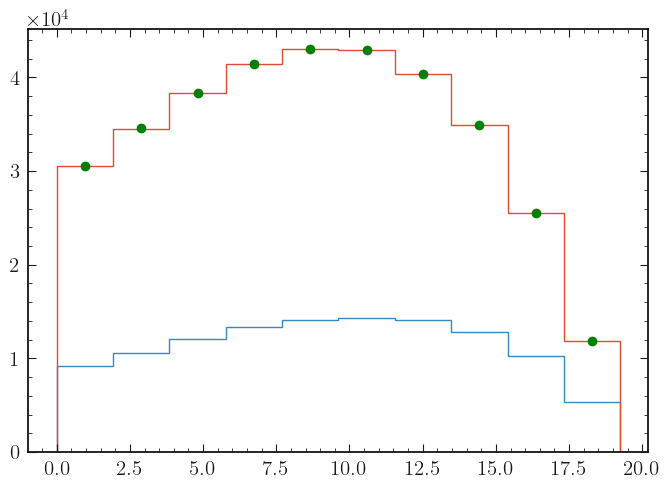

In [23]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')